Scaler saved successfully!
Epoch 1/50


/opt/anaconda3/envs/Model/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0373
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0019
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0020
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0016
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0013
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0014
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0010
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0010
Epoch 13/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012
Epoch 14/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011
Epoch 15/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.4390e-04
Epoch 16/50

Model saved successfully!
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train RMSE: 53.673019556600835, Test RMSE: 31.212875960683807


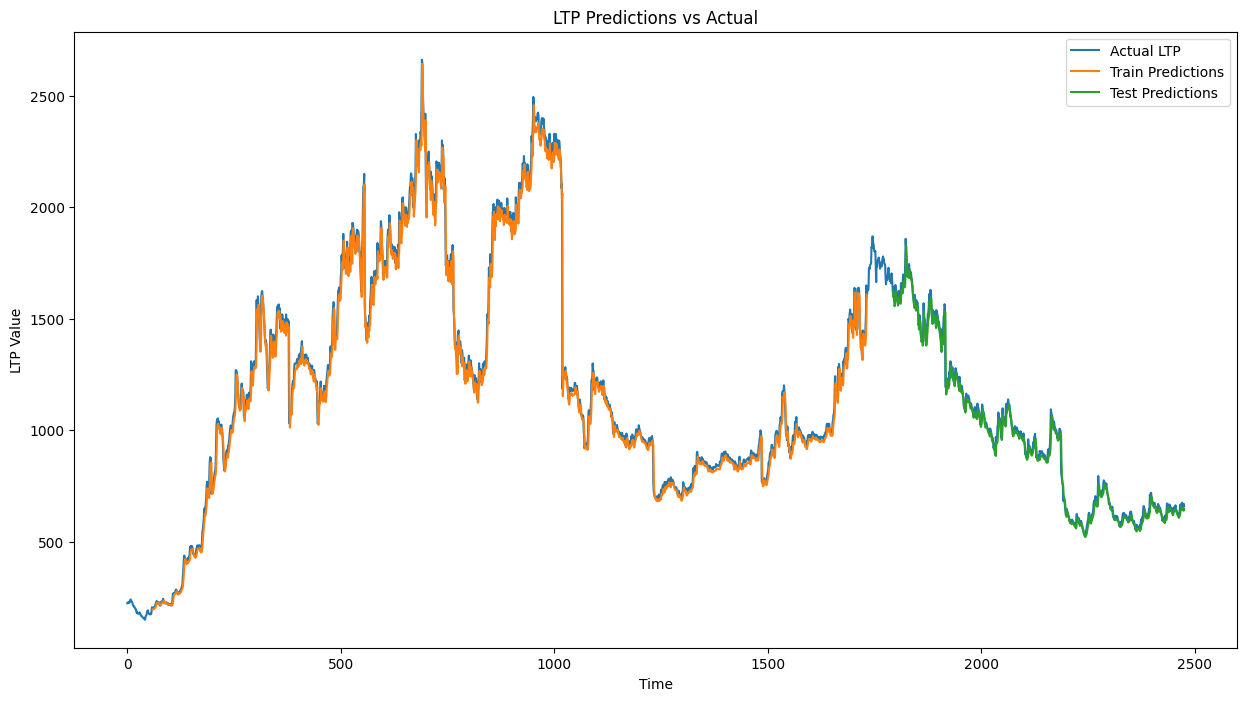

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib

# Function to preprocess the data
def preprocess_data(file_path, time_step=60):
    # Load and clean the data
    df_stock = pd.read_csv(file_path)
    df_stock = df_stock.rename(columns={'% Change': 'Change'})
    df_stock['Date'] = pd.to_datetime(df_stock['Date'], format='%d/%m/%Y')
    df_stock['Ltp'] = df_stock['Ltp'].str.replace(',', '').astype(float)
    
    # Sort data and reset index
    data = df_stock.sort_values(by='Date').reset_index(drop=True)
    
    # Extract LTP values and scale data
    ltp_data = data['Ltp'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(ltp_data)
    
    # Save the scaler
    joblib.dump(scaler, "scaler.pkl")
    print("Scaler saved successfully!")
    
    # Create datasets for training and testing
    training_size = int(len(scaled_data) * 0.70)
    train_data = scaled_data[:training_size]
    test_data = scaled_data[training_size:]
    
    # Create time-series datasets
    def create_dataset(data, time_step):
        X, y = [], []
        for i in range(len(data) - time_step):
            X.append(data[i:i + time_step, 0])
            y.append(data[i + time_step, 0])
        return np.array(X), np.array(y)
    
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    
    # Reshape data for LSTM input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    return X_train, y_train, X_test, y_test, scaler, data, time_step

# Build and train the LSTM model
def build_and_train_model(X_train, y_train, epochs=50, batch_size=32):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)
    
    # Save the model
    model.save("lstm_model.h5")
    print("Model saved successfully!")
    
    return model

# Predict and visualize results
def predict_and_visualize(model, scaler, X_train, y_train, X_test, y_test, data, time_step):
    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # Inverse transform predictions
    train_predict = scaler.inverse_transform(train_predict)
    y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
    test_predict = scaler.inverse_transform(test_predict)
    y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate RMSE
    train_rmse = np.sqrt(np.mean((train_predict - y_train_inverse) ** 2))
    test_rmse = np.sqrt(np.mean((test_predict - y_test_inverse) ** 2))
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
    
    # Visualization
    train_index = range(time_step, len(train_predict) + time_step)
    test_index = range(int(len(data) * 0.7) + time_step, len(data))  # Fixed this line
    
    plt.figure(figsize=(15, 8))
    plt.plot(data['Ltp'], label="Actual LTP")
    plt.plot(train_index, train_predict.flatten(), label="Train Predictions")
    plt.plot(test_index, test_predict.flatten(), label="Test Predictions")
    plt.xlabel("Time")
    plt.ylabel("LTP Value")
    plt.title("LTP Predictions vs Actual")
    plt.legend()
    plt.show()

# Main script
if __name__ == "__main__":
    # Load and preprocess data
    file_path = "NULBdata.csv"  # Update with your dataset file path
    X_train, y_train, X_test, y_test, scaler, data, time_step = preprocess_data(file_path)
    
    # Build and train the model
    model = build_and_train_model(X_train, y_train)
    
    # Predict and visualize results
    predict_and_visualize(model, scaler, X_train, y_train, X_test, y_test, data, time_step)


In [5]:
# Save the model to an H5 file
model.save('stock_lstm_model2.h5')

print("Model saved successfully!")


Model saved successfully!
